In [2]:
import pandas as pd
import torch

In [3]:
dataset = pd.read_csv('iris.csv', names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
feature_cols = [col for col in dataset.columns]
feature_cols.remove('class')
class_names = list(dataset['class'].unique())
for col in feature_cols:
    #normalize dataset
    dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())
#set feature and class names
dataset['class'] = dataset['class'].map({species:i for i, species in enumerate(class_names)})

In [4]:
X = torch.tensor(dataset[feature_cols].to_numpy(), dtype=torch.float64)
Y = torch.tensor(dataset['class'].to_numpy(), dtype=torch.float64).unsqueeze(1)

In [5]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan


model = SingleTaskGP(train_X=X, train_Y=Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

In [6]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(X)

In [7]:
from torch.optim import SGD

optimizer = SGD([{"params": model.parameters()}], lr=0.025)

In [8]:
NUM_EPOCHS = 150

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(X)
    # Compute negative marginal log likelihood
    loss = -mll(output, model.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 25 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            #f"lengthscale: {model.covar_module.lengthscale:>4.3f} "
            f"noise: {model.likelihood.noise.item():>4.3f}"
        )
    optimizer.step()

Epoch  25/150 - Loss: 0.912 noise: 0.601
Epoch  50/150 - Loss: 0.833 noise: 0.509
Epoch  75/150 - Loss: 0.751 noise: 0.427
Epoch 100/150 - Loss: 0.668 noise: 0.355
Epoch 125/150 - Loss: 0.585 noise: 0.293
Epoch 150/150 - Loss: 0.504 noise: 0.241


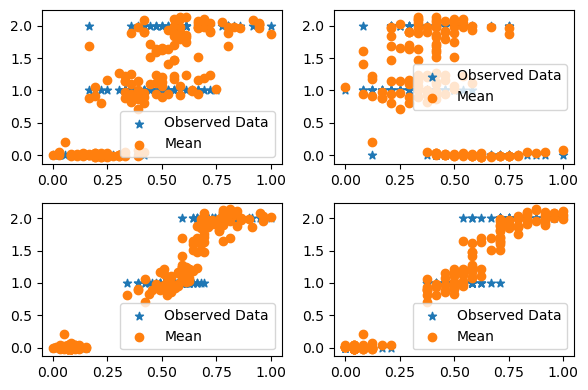

In [31]:
model.eval()
from matplotlib import pyplot as plt

# Initialize plot
f, ax = plt.subplots(2, 2, figsize=(6, 4))
axs = ax.flatten()
# test model on 101 regular spaced points on the interval [0, 1]
# no need for gradients
with torch.no_grad():
    posterior = model.posterior(X)
    lower, upper = posterior.mvn.confidence_region()
    for dim, axis in enumerate(axs):
            cur_dim = X[:,dim]
            err_up = Y.squeeze() + upper
            err_low = Y.squeeze() - lower
            # compute posterior
            # Get upper and lower confidence bounds (2 standard deviations from the mean)
            # Plot training points as black stars
            axis.scatter(cur_dim.cpu().numpy(), Y.cpu().numpy(), marker="*")
            # Plot posterior means as blue line
            axis.scatter(cur_dim.cpu().numpy(), posterior.mean.cpu().numpy()
                         )
            # Shade between the lower and upper confidence bounds
            err = [err_up, err_low]
            # axis.errorbar(
            #     cur_dim.cpu().numpy(), posterior.mean.cpu().numpy(), err, alpha=0.5
            # )
            axis.legend(["Observed Data", "Mean", "Confidence"])
plt.tight_layout()

In [33]:
upper, lower = model.posterior(X).mvn.confidence_region()
(lower)

tensor([0.1230, 0.2115, 0.1558, 0.1987, 0.1379, 0.2146, 0.2175, 0.1212, 0.2947,
        0.2060, 0.1714, 0.1632, 0.2208, 0.3066, 0.3804, 0.4906, 0.2434, 0.1293,
        0.2543, 0.1712, 0.2240, 0.1829, 0.3055, 0.2725, 0.2661, 0.2445, 0.1841,
        0.1341, 0.1487, 0.1838, 0.1885, 0.2334, 0.3644, 0.3569, 0.2060, 0.1833,
        0.2396, 0.2060, 0.2617, 0.1283, 0.1475, 0.6740, 0.2457, 0.3421, 0.2567,
        0.2281, 0.1940, 0.1769, 0.1534, 0.1296, 1.3137, 1.2661, 1.4553, 1.4380,
        1.4111, 1.3212, 1.4319, 1.1782, 1.2179, 1.4013, 1.4393, 1.2751, 1.2655,
        1.3568, 1.0586, 1.1785, 1.4418, 1.0453, 1.7091, 1.1239, 1.7284, 1.0874,
        1.6693, 1.2861, 1.1080, 1.1916, 1.4112, 1.6768, 1.3739, 0.9363, 1.1711,
        1.1031, 1.0556, 1.8113, 1.5099, 1.3877, 1.3580, 1.4441, 1.1259, 1.3188,
        1.3603, 1.2811, 1.1251, 1.1954, 1.2564, 1.0741, 1.1578, 1.1103, 1.1109,
        1.1585, 2.4410, 2.1028, 2.2344, 2.1022, 2.3270, 2.3641, 2.0729, 2.2558,
        2.2296, 2.3416, 1.9372, 2.0753, 